In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import joblib
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass
import os

In [ ]:
@dataclass(init=True, repr=True, eq=False, order=False, unsafe_hash=False, frozen=False)
class ModelBenchmark:
    """
    A comprehensive benchmarking class for evaluating different machine learning models
    on enzyme kinetic datasets with various data splitting strategies.
    
    This class encapsulates the entire machine learning pipeline including data preprocessing,
    train/validation/test splitting, model initialization, training, and prediction.
    Supports multiple traditional ML algorithms and data splitting methods for robust evaluation.
    
    Attributes:
        data (pd.DataFrame | str): Input dataset as DataFrame or path to joblib file
        model_type (str): Type of model to use ('CAT', 'GBM', 'LR', 'RF', 'SVR', 'XGB')
        split_method (str): Data splitting strategy ('random', 'cold_mols', 'cold_proteins', 'load_from_file')
    
    Methods:
        __post_init: Post-initialization to load and validate input data
        rename_data_columns: Rename DataFrame columns using a mapping dictionary
        data_preprocessing: Preprocess features and labels for model training
        split_data: Split dataset into train/validation/test sets
        model_init: Initialize the specified model type
        fit: Train the model on training data
        load_model_from_file: Load model from file
        save_model_to_file: Save model to file
        predict: Generate predictions using the trained model
        plot_pred_label_scatter_plot: Create a scatter plot of predictions vs true labels
        add_pred_to_data_with_pred: Add model predictions to the data_with_pred
    """
    data: pd.DataFrame | str
    model_type: str
    split_method: str


    '''
    def __init__(self, data, model_type, split_method, *args, **kwargs):
        """Initialize the BenchMarkModel with data, model type, and split method."""
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Data must be a pandas DataFrame.")
        self.data = data
        self.model_type = model_type
        self.split_method = split_method
        self.args = args
        self.kwargs = kwargs'''

    def __post_init__(self):
        """
        Post-initialization method to load and validate input data.
        
        Handles both DataFrame objects and file paths to joblib files.
        Ensures data integrity and proper format for downstream processing.
        
        Raises:
            ValueError: If data type is unsupported or file loading fails
        """
        # Debug information for data type checking
        print(f"Initial data type: {type(self.data)}")
        
        if isinstance(self.data, pd.DataFrame):
            print("Data is already a DataFrame")
            # Create a copy to avoid modifying original data
            self.data = self.data.copy()
        elif isinstance(self.data, str):
            print(f"Loading data from: {self.data}")
            try:
                # Load data from joblib file
                self.data = joblib.load(self.data)
                print(f"Data loaded successfully, type: {type(self.data)}")
            except Exception as e:
                print(f"Error loading data: {e}")
                raise ValueError(f"Could not load data from {self.data}: {e}")
        else:
            raise ValueError("Data must be a pandas DataFrame or a valid file path.")
        
        
        if self.split_method=="random_split":
            self.split_method = "random"
        elif self.split_method == "cold_molecules":
            self.split_method = "cold_mols"
        elif self.split_method not in ["random", "cold_mols", "cold_proteins", "load_index_from_file"]:
            raise ValueError(f"Unknown split method: {self.split_method}")
        
        if self.model_type not in ["CAT","CNN","GBM","LR","MLP","RF","SVR","TRANS","XBG","Diffusion"]:
            raise ValueError(f"Unknown model type: {self.model_type}")
        
        
    
    def rename_data_columns(self, rename_dict):
        """
        Rename DataFrame columns using the provided mapping dictionary.
        
        Args:
            rename_dict (dict): Dictionary mapping old column names to new ones
            
        Returns:
            ModelBenchmark: Returns self for method chaining
        """
        self.data = self.data.rename(columns=rename_dict)
        return self

    def data_preprocessing(self, *args, **kwargs):
        """
        Preprocess the dataset by preparing features and labels for model training.
        
        This method handles column renaming, feature concatenation, and label extraction.
        Currently supports traditional ML models that require concatenated features.
        
        Args:
            *args: Variable length argument list
            **kwargs: Arbitrary keyword arguments including:
                rename_dict (dict, optional): Column renaming mapping
                
        Returns:
            ModelBenchmark: Returns self for method chaining
            
        Raises:
            ValueError: If required feature columns are missing
        """
        # Apply column renaming if specified
        if kwargs.get("rename_dict"):
            print(f"Data columns before renaming: {self.data.columns.tolist()}")
            self.rename_data_columns(kwargs["rename_dict"])
            print(f"Data columns after renaming: {self.data.columns.tolist()}")
        else:
            print(f"Data columns without renaming: {self.data.columns.tolist()}")

        # Validate required columns exist
        if ("metabolite_features" not in self.data.columns) or ("protein_features" not in self.data.columns):
            raise ValueError("Data is missing required feature columns or wrong column name.")
        
        # Process data for traditional ML models
        if self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]:
            # Concatenate metabolite and protein features into a single feature vector
            # This creates a flat feature representation suitable for traditional ML algorithms
            self.X = np.array([np.concatenate([m, p]) for m, p in zip(self.data["metabolite_features"], self.data["protein_features"])])
            self.y = self.data["label"]
        return self
    
    def split_data(self, *args, **kwargs):
        """
        Split the dataset into training, validation, and test sets based on the specified method.
        
        Supports multiple splitting strategies:
        - Random split: Standard random partitioning (70% train, 15% val, 15% test)
        - Cold molecules: Split by unique molecules (to be implemented)
        - Cold proteins: Split by unique proteins (to be implemented)
        - Load from file: Use pre-computed split indices
        
        Args:
            *args: Variable length argument list
            **kwargs: Arbitrary keyword arguments including:
                save_index_path (str, optional): Path to save split indices
                index_file_path (str, required for load_index_from_file): Path to load pre-computed indices

        Returns:
            ModelBenchmark: Returns self for method chaining
            
        Raises:
            ValueError: If split method is unknown or indices don't match data length
        """
        # Generate train/validation/test indices based on split method
        if self.split_method == "random" or self.split_method == "random_split":
            # Standard random split: 70% train, 15% validation, 15% test
            self.train_index, self.temp_index = train_test_split(np.arange(len(self.data)),test_size=0.3, shuffle=True, random_state=42)
            self.val_index, self.test_index = train_test_split(self.temp_index, test_size=0.5, shuffle=True, random_state=42)

        elif self.split_method == "cold_mols":
            # TODO: Implement cold molecules split logic
            # This would split by unique molecules to test generalization to new compounds
            pass
        elif self.split_method == "cold_proteins":
            # TODO: Implement cold proteins split logic  
            # This would split by unique proteins to test generalization to new enzymes
            pass
        elif self.split_method == "load_index_from_file":
            # Load pre-computed split indices from JSON file
            if "index_file_path" not in kwargs:
                raise ValueError("index_file_path must be provided for load_index_from_file split method.")
            with open(kwargs["index_file_path"], "r") as f:
                indices = json.load(f)
                self.train_index = np.array(indices["train_index"])
                self.val_index = np.array(indices["val_index"])
                self.test_index = np.array(indices["test_index"])
                
            # Validate that indices cover all data points exactly once
            if len(self.train_index)+ len(self.val_index) + len(self.test_index) != len(self.data):
                raise ValueError("Indices from file do not match the length of the data.")   
            
        else:
            raise ValueError(f"Unknown split method: {self.split_method}")
        
        print("get split indices successfully")
        
        # Create feature and label subsets for each split
        self.train_X = self.X[self.train_index]
        self.train_y = self.y[self.train_index]
        self.val_X = self.X[self.val_index]
        self.val_y = self.y[self.val_index]
        self.test_X = self.X[self.test_index]
        self.test_y = self.y[self.test_index]

        # Save split indices to file if specified
        if kwargs.get("save_index_path"):
            with open(kwargs["save_index_path"], "w") as f:
                json.dump({
                    "train_index": self.train_index.tolist(),
                    "val_index": self.val_index.tolist(),
                    "test_index": self.test_index.tolist()
                }, f)
            print(f"save split indices to {kwargs.get('save_index_path')}")
        return self
    
    def model_init(self, *args, **kwargs):
        """
        Initialize the specified machine learning model with given parameters.
        
        Supports various traditional ML algorithms including tree-based methods,
        linear models, and support vector machines.
        
        Args:
            *args: Variable length argument list passed to model constructor
            **kwargs: Arbitrary keyword arguments passed to model constructor
            
        Returns:
            ModelBenchmark: Returns self for method chaining
            
        Raises:
            ImportError: If required model library is not installed
        """
        print(f"Training {self.model_type}(traditional) model...")
        
        # Initialize model based on specified type
        if self.model_type == "CAT":
            # CatBoost Gradient Boosting
            import catboost as cat
            self.model = cat.CatBoostRegressor( *args, **kwargs)
        elif self.model_type == "GBM":
            # Scikit-learn Gradient Boosting
            from sklearn.ensemble import GradientBoostingRegressor
            self.model = GradientBoostingRegressor( *args, **kwargs)
        elif self.model_type == "LR":
            # Linear Regression
            from sklearn.linear_model import LinearRegression
            self.model = LinearRegression( *args, **kwargs)
        elif self.model_type == "RF":
            # Random Forest with fixed random state for reproducibility
            from sklearn.ensemble import RandomForestRegressor
            self.model = RandomForestRegressor(random_state=42)
        elif self.model_type == "SVR":
            # Support Vector Regression
            from sklearn.svm import SVR
            self.model = SVR( *args, **kwargs)
        elif self.model_type == "XGB":
            # XGBoost Gradient Boosting
            import xgboost as xg
            self.model = xg.XGBRegressor( *args, **kwargs)
        else:
            """TODO: Implement initialization for other model types"""
        
        print(f"Model initialized: {self.model_type} with args={args}, kwargs={kwargs}")
        return self

    def fit(self, *args, **kwargs):
        """
        Train the initialized model on the training dataset.
        
        Uses the preprocessed training features (train_X) and labels (train_y)
        to fit the model parameters.
        
        Args:
            *args: Variable length argument list passed to model.fit()
            **kwargs: Arbitrary keyword arguments passed to model.fit()
            
        Returns:
            ModelBenchmark: Returns self for method chaining
        """
        if self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]:
            # Train the model using standard scikit-learn API
            self.model.fit(self.train_X, self.train_y, *args, **kwargs)
            print(f"Model {self.model_type} trained successfully.")
            return self
        else:
            """
            TODO: Implement training logic for other model types
            """
            pass
    
    def load_model_from_file(self, model_path):
        """
        Load a pre-trained model from file.
        
        Args:
            model_path (str): Path to the saved model file
            
        Returns:
            ModelBenchmark: Returns self for method chaining
        """
        if self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]:
            self.model = joblib.load(model_path)
            print(f"Model loaded from: {model_path}")
            return self
        else:
            """
            TODO: Implement model loading logic for other model types
            """
            pass
    
    def save_model_to_file(self, model_path):
        """
        Save the trained model to file.
        
        Args:
            model_path (str): Path where to save the model
        """
        if hasattr(self, 'model'):
            # Save the model using joblib for traditional ML models
            if self.model in ["GBM", "LR", "RF", "SVR", "XGB"]:
                joblib.dump(self.model, model_path)
                print(f"Model saved to: {model_path}")
            return self   
        else:
            raise ValueError("No model to save. Please train a model first.")
    
    def predict(self, X):
        """
        Generate predictions using the trained model.
        
        Args:
            X (numpy.ndarray): Input features for prediction
            
        Returns:
            numpy.ndarray: Model predictions
        """
        if self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]:
            return self.model.predict(X)
        
    def plot_pred_label_scatter_plot(self, *args, **kwargs):
        """
        Generate a scatter plot of model predictions vs true labels.
        
        This method visualizes the model's performance by plotting predicted values
        against actual labels, allowing for quick assessment of prediction quality.
        """


        plt.figure(figsize=(8, 6))
        plt.scatter(self.test_y, self.predict(self.test_X), alpha=0.5)
        plt.plot([self.test_y.min(), self.test_y.max()], [self.test_y.min(), self.test_y.max()], linestyle="--", color="red", lw=2)
        plt.ylabel("predicted")
        plt.xlabel("label")
        plt.title(f"{self.model_type} Model Predictions vs Label")
        plt.tight_layout()
        if kwargs.get("save_path"):
            plt.savefig(kwargs["save_path"])
            print(f"Scatter plot saved to {kwargs['save_path']}")
        
        plt.show()
    def add_pred_to_data_with_pred(self, data_with_pred_path, *args, **kwargs):
        """
        Add model predictions to the original DataFrame.
        """
        predictions = self.predict(self.X)
        if os.path.exists(data_with_pred_path):
            data_with_pred = joblib.load(data_with_pred_path)
            if self.model_type+"_pred" in data_with_pred.columns:
                raise ValueError(f"Predictions already exist in {data_with_pred_path}. Please choose a different path or remove the existing file.")
        else:
            data_with_pred = self.data.copy()
        data_with_pred[self.model_type+"_pred"] = predictions
        joblib.dump(data_with_pred, data_with_pred_path)
        return self
    
    
    


In [11]:
# Initialize the ModelBenchmark with enzyme kinetic data, Linear Regression model, and random split
bench_mark_model = ModelBenchmark(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="LR",
                                   split_method="random",)
# Preprocess the data and rename the target column to 'label'
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})
# Execute the complete ML pipeline: split data, initialize model, and train
bench_mark_model.split_data().model_init().load_model_from_file("./../../A03_models/random_split/LR model_Catpred.joblib")
# bench_mark_model.split_data().model_init().fit()

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>
Data columns before renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'log10kcat_max', 'metabolite_features', 'protein_features']
Data columns after renaming: ['Sequence', 'sequence_source', 'uniprot', 'Smiles', 'value', 'ec', 'log10_value', 'reactant_smiles', 'product_smiles', 'label', 'metabolite_features', 'protein_features']
get split indices successfully
Training LR(traditional) model...
Model initialized: LR with args=(), kwargs={}
Model loaded from: ./../../A03_models/random_split/LR model_Catpred.joblib


ModelBenchmark(data=                                                Sequence sequence_source  \
0      MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...           sabio   
1      MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...          brenda   
2      MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...          brenda   
3      MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...          brenda   
4      MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...           sabio   
...                                                  ...             ...   
23146  MTVFSAIPPISCWFTGRTPASWDKTMDMQTSFLDRLFEEGLLIETG...           sabio   
23147  MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...          brenda   
23148  MALRACGLIIFRRCLIPKVDNNAIEFLLLQASDGIHHWTPPKGHVE...           sabio   
23149  MTTAPTPSIFEPARLGPLTLRNRIVKAATFEGVMPRGAVSDDLINF...  uniprot_search   
23150  MLKVISSLLFYMTASLMAVASPLAHSGESRGEYPTVSEIPVGEVRL...          brenda   

          uniprot                                             Smile

In [12]:
# Generate predictions on the entire feature set
bench_mark_model.predict(bench_mark_model.X)

array([ 2.2598267 , -0.06915283, -0.0513916 , ..., -0.26843262,
        0.8468933 ,  1.2799988 ], dtype=float32)

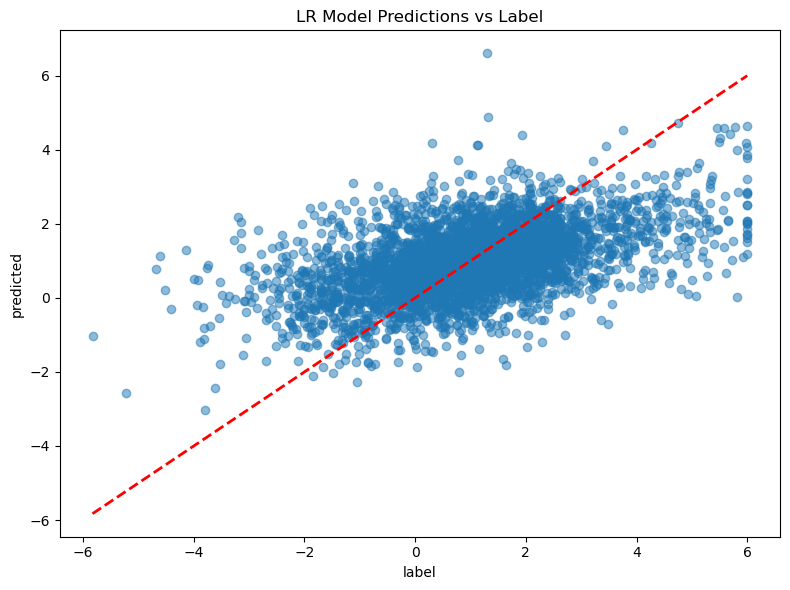

In [14]:
# bench_mark_model.add_pred_to_data_with_pred("./../../A01_dataset/kcat_with_pred.joblib")
bench_mark_model.plot_pred_label_scatter_plot()